In [1]:
N = 10000
N_init = 1000
pwd = 'all_images/image_short'
pwd_data = 'all_data/data_short'

In [2]:
import os
import json
import pickle
import random
from sim.sim_use import make_random_paire_list_instr
from exploration.history import History
from exploration.imgep.features import Features
import numpy as np
from exploration.env.func import Env
from  exploration.imgep.OptimizationPolicy import OptimizationPolicykNN
from exploration.imgep.intrinsic_reward import IR

In [3]:
with open(os.path.join(pwd,'config_plots.json'),'rb') as f:
    config = json.load(f)

In [4]:
with open(os.path.join(pwd_data,'modules.json'),'rb') as f:
    modules_dict = json.load(f)
modules = modules_dict["modules"]

In [5]:
with open(os.path.join(pwd_data,'config.json'),'rb') as f:
    config_data = json.load(f)

In [6]:
H = History(N)

In [7]:
config

{'files': [{'folder': 'all_data/data_short',
   'file': 'history_kNN_2_N_10000_lp_0.pkl',
   'name': 'imgep_ir k=2,N=10000',
   'k': 2,
   'N': 10000,
   'type': 'imgep_ir'},
  {'folder': 'all_data/data_short',
   'file': 'history_kNN_2_N_10000_no_lp_0.pkl',
   'name': 'imgep_no_ir k=2,N=10000',
   'k': 2,
   'N': 10000,
   'type': 'imgep_no_ir'}],
 'N_init': 1000,
 'N': 10000,
 'image_folder': 'all_images/image_short',
 'random': {'folder': 'all_data/data_short',
  'N': 10000,
  'file': 'history_rand_N_10000_0.pkl',
  'name': 'random'},
 'num_bank': 4,
 'num_addr': 20,
 'ks': [2]}

In [8]:
data = config["files"][0]

In [9]:
with open(os.path.join(data["folder"],data["file"]), "rb") as f:
    sample = pickle.load(f)
    content = sample["memory_perf"]

In [10]:
H.memory_program["core0"] = sample["memory_program"]["core0"]
H.memory_program["core1"] = sample["memory_program"]["core1"]
for key in sample["memory_perf"].keys():
    H.memory_perf[key]= list(sample["memory_perf"][key])

In [11]:
F = Features()

In [12]:
ratios_type = []
other_type = []
for m in modules:
    if m["type"] in ["miss_ratios","miss_ratios_detailled","miss_count"]:
        ratios_type.append(m)
    else:
        other_type.append(m)

In [13]:
import torch
import torch.nn as nn
from torch import distributions

In [14]:
class Tool:
    def __init__(self):
        #self.rep_ac = Representation_action(env.Na)
        #self.rep_cl = Representation(env.Nx,env.Ny)
        pass
    def Qf(self,state:np.ndarray,action:np.ndarray):
        return self.q(state,action)
    def Qf_target(self,state:np.ndarray,action:np.ndarray):
        return self.q_target(state,action)
    def update_target_net(self):
        for (name_q, param_q),(name_q_target,param_q_target) in zip(self.q.state_dict().items(),self.q_target.state_dict().items()):
            param_q_target.copy_(self.tau*param_q + (1.0 - self.tau)*param_q_target)
    def updatePi(self,
                 api:dict,
                 logpi,
                 state:dict):
        advantage = self.Qf(state,api).squeeze()
        advantage = advantage.detach()
        NegativPseudoLoss = torch.mean(torch.mul(logpi.squeeze(),advantage)) 
        NegativPseudoLoss.backward()
        self.optimizerpi.step()
        return NegativPseudoLoss
    def updateQ(self,
                states:dict,
                actions:dict,
                targets):  
        for k in range(self.k):
            self.optimizer_q.zero_grad()
            loss = F.mse_loss(self.Qf(states,actions).squeeze(),targets.squeeze())
            loss.backward()
            self.optimizer_q.step()
        return loss
    def epsilon_greedy_policy(self,state:dict):
        if np.random.binomial(1,self.epsilon):
            out = np.random.randint(0,self.Na)
        else:
            out = self.p([state["cat"]],[state["mouse"]])
            out = int(out.detach().item())
        return out 

In [210]:
class Policy(nn.Module):
    def __init__(self,
                 first_layer_size:int,
                 subdivision: np.ndarray,
                ):
        super(Policy,self).__init__()
        self.first_layer_size = first_layer_size
        self.subdivision = subdivision
        self.linear1 = nn.Linear(self.first_layer_size,16)
        self.linear2 = nn.Linear(16,16)
        self.linear3 = nn.Linear(16,20)
        self.actv = nn.Sigmoid()
    def forward(self,x,logit = False):
        x = torch.Tensor(x)
        x = torch.mul(x,1.0/5000)
        out = self.linear1(x)
        out = self.actv(out)
        out = self.linear2(out)
        out  =self.actv(out)
        logits = self.linear3(out)
        #print("logits", logits.shape)
        dist = distributions.Categorical(torch.nn.functional.softmax(logits,dim=1))
        action = dist.sample([1]).squeeze()
        if logit:
            return action,logits
        else:
            return action
    

In [211]:
class Q(nn.Module):
    def __init__(self,first_layer_size):
        super(Q,self).__init__()
        self.linear1 = nn.Linear(20,20)
        self.encod = torch.eye(20)
    def forward(self,state,action):
        state = torch.Tensor(state*1.0/5000)
        out = self.linear1(state)
        out = torch.mul(self.encod[action],out)
        out = torch.sum(out)
        return out

In [212]:
policy = Policy(20,ratios_type[0]["bins"])

In [213]:
print(len(policy.subdivision))

21


In [214]:
q = Q(first_layer_size = 20)
q_target = Q(first_layer_size = 20)

In [215]:
feature = F.data2feature(H.memory_perf,ratios_type[0])
hist,_ = np.histogram(feature,bins=ratios_type[0]["bins"])

In [216]:
q(hist.reshape((1,-1)),4)

tensor(-0.2113, grad_fn=<SumBackward0>)

In [217]:
policy(hist.reshape((1,-1)))

tensor(0)

In [248]:
class Buffer:
    def __init__(self):
        self.memory = {"state":[],"action":[],"reward":[],"new_state":[]}
    def store(self,dict_):
        for key in self.memory.keys():
            self.memory[key].append(dict_[key])
    def sample(self,N):
        """
        returns dictionnary of state, action, new_state and reward
        """
        assert(type(N)==int and N>0 and N<=len(self.memory["state"]))
        selection = torch.randint(0,len(self.memory["state"]),(N,))
        state = np.array([self.memory["state"][j] for j in selection])
        action = np.array([self.memory["action"][j] for j in selection])
        new_state = np.array([self.memory["new_state"][j] for j in selection])
        reward = np.array([self.memory["reward"][j] for j in selection])
        return {"state":state, "action":action, "new_state":new_state,"reward": reward}
    def __len__(self):
        return len(self.memory["state"])



In [344]:
class Agent(Tool):
    def __init__(self,
                policy:Policy,
                tau:float=0.01):
        Tool.__init__(self)
        self.policy = policy
        self.buffer = buffer
        self.q = q
        self.q_target = q_target
        self.tau = 0.01
        self.gamma = .95
        self.k = 3
        self.optimizerpi = optim.Adam(self.p.parameters(),lr=   lr_pi)
        self.optimizer_q = optim.Adam(self.q.parameters(), lr = lr_q)


In [342]:
class GoalGenerator(Features,Tool):
    def __init__(self,
                 num_bank:int,
                 modules:list,
                 policy:Policy,
                 q:Q,
                 q_target:Q,
                 H:History,
                 buffer:Buffer,
                 agent:Agent
                 ):
        #super().__init__()
        Features.__init__(self)
        Tool.__init__(self)
        self.num_bank = num_bank
        self.k_time = 0
        self.k_miss = 0
        self.modules = modules
        #self.policy = policy
        #self.buffer = buffer
        #self.q = q
        #self.q_target = q_target
        #self.tau = 0.01
        #self.gamma = .95
        self.history = H
        self.agent = agent
        
    def rand(self,stat)->np.ndarray:
        min_ = stat.min(axis=-1)
        max_ = stat.max(axis=-1)
        out = np.random.uniform((1-np.sign(min_)*0.6)*min_,4.0*max_)
        return out
    def diversity_representation(self,module:dict):
        feature = self.data2feature(self.history.memory_perf,m)
        hist,_ = np.histogram(feature,bins=m["bins"])
        return hist
    def __call__(self,H:History, module:str)->np.ndarray:
        assert module in self.modules, f"module {module} unknown"
        stat = self.diversity_representation(module)
        if module["type"] not in ["miss_ratios","miss_ratios_detailled","miss_count"]:
            out = self.rand(stat)
        else:
            state  = self.diversity_representation(module)
            module["state"] = state
            #if np.random.binomial(1,0.1):
            if False:
                out = self.rand(stat)
            else:
                action = self.policy(state.reshape((1,-1))).detach().numpy()
                print("action", action)
                out = np.random.uniform(module["bins"][action],module["bins"][action+1])
                module["action"] = action
        self.current_module = module
        return out
    def evaluate_reward(self,state,new_state):
        return np.sum(new_state>0) - np.sum(state)   
    def update(self,goal):
        if self.current_module["type"] in ["miss_ratios","miss_ratios_detailled","miss_count"]:
            state = self.current_module["state"]
            new_state  = self.diversity_representation(self.current_module)
            reward = self.evaluate_reward(state,new_state)
            self.buffer.store({"state":state,"action":self.current_module["action"],"reward":reward,"new_state":new_state})
            sample = self.buffer.sample(min(5,len(self.buffer)))
            a_prim = self.policy(sample["state"])
            targets = torch.Tensor(sample["reward"]) + self.gamma*self.Qf_target(sample["new_state"],a_prim).detach().squeeze()
            loss_ = self.updateQ(sample["state"],sample["action"],targets)
            print("targets",targets)
            print("b")
            return 0
            #update policy and value function
            #print(buffer.memory)
            #print("buffer",)
            
            

In [324]:
class IMGEP_:
    """
    N: int. The experimental budget
    N_init: int. Number of experiments at random
    H: History. Buffer containing codes and signature pairs
    G: GoalGenerator.
    Pi: OptimizationPolicy.
    """
    def __init__(self,
                 N:int,
                 N_init:int,
                 E:Env,
                 H:History,
                 G:GoalGenerator, 
                 Pi:OptimizationPolicykNN,
                 ir:IR,
                 modules:list[dict],
                 periode:int = 1,
                 max_len:int = 100):
        self.N = N
        self.env = E
        self.H = H
        self.G = G
        self.N_init = N_init
        self.Pi = Pi
        self.ir = ir
        self.periode = periode
        self.modules = modules 
        self.max_len = max_len
        self.start = 0
        self.periode_expl = 10
        self.k = 0
    def take(self,sample:dict,N_init:int): 
        """Takes the ``N_init`` first steps from the ``sample`` dictionnary to initialize the exploration. 
        Then the iterator i is set to N_init directly
        """
        print("sampl", sample.keys())
        for key in sample["memory_perf"].keys():
            self.H.memory_perf[key]= list(sample["memory_perf"][key][:N_init])
        self.H.memory_program["core0"] = sample["memory_program"]["core0"][:N_init]
        self.H.memory_program["core1"] = sample["memory_program"]["core1"][:N_init]
        self.start = N_init

In [325]:
class IMGEP(IMGEP_):
    def __init__(self,
                 N:int,
                 N_init:int,
                 E:Env,
                 H:History,
                 G:GoalGenerator, 
                 Pi:OptimizationPolicykNN,
                 ir:IR,
                 modules:list[dict],
                 periode:int = 1,
                 max_len:int = 100):
        super(IMGEP,self).__init__(N,N_init, En,H,G,Pi,ir=None, modules = modules, periode = periode, max_len = max_len)
    def __call__(self,intr_reward=True):
        
        """Performs the exploration.
        intr_reward:bool. If True, the exploration uses intrinsic reward based on diversity
        """
        time_explor = 0
        for i in range(self.start,self.N+1):
            if i%100==0:
                print(f"{i} iterations")
            if i<time_explor:
                continue
            if i<self.N_init:
                parameter = make_random_paire_list_instr(self.max_len,num_addr=self.env.num_addr)
            else:
                if intr_reward:
                    #Sample target goal
                    if (i-self.N_init)%(self.periode_expl*self.periode)==0:
                        self.ir(self.N)
                        time_explor = i + self.ir.num_iteration*len(self.ir.modules)
                        print("time explor", time_explor)
                        module = self.ir.choice()
                        goal = self.G(self.H, module = module)
                        continue
                    elif (i-self.N_init)%self.periode==0:
                        module = self.ir.choice()
                        goal = self.G(self.H, module = module)
                else:
                    if (i-self.N_init)%self.periode==0 and i>=self.N_init:
                        module = random.choice(self.modules)
                        goal = self.G(self.H, module = module)
                #print("module", module)
                #print("goal",goal)
                parameter = self.Pi(goal,self.H, module)
            observation = self.env(parameter)
            self.H.store({"program":parameter}|observation)
            if i>=self.N_init:
                self.G.update(goal)
                return 0

In [326]:
num_bank = 4

In [327]:
buffer = Buffer()

In [328]:
G = GoalGenerator(num_bank,ratios_type,policy,q,q_target,H,buffer)

In [329]:
G.Qf_target(hist,-1)

tensor(0.1269, grad_fn=<SumBackward0>)

In [330]:
feature = F.data2feature(H.memory_perf,ratios_type[0])
hist,_ = np.histogram(feature,bins=ratios_type[0]["bins"])

In [331]:
N_init = 100
N = 1000
periode  =5
max_len = 50
num_banks = 4
num_addr = 20
mutation_rate = 0.1


In [332]:
periode = config_data["periode"]
mutation_rate = config_data["mutation_rate"]
N = config_data["N"]
N_init = config_data["N_init"]
num_bank = config_data["num_bank"]
max_len = config_data["max_len"]
min_len = config_data["min_len"]
folder = config_data["folder"]
num_addr = config_data["num_addr"]
num_iteration = config_data["num_iteration"]

In [333]:
En = Env(repetition=1,num_banks = num_bank,num_addr = num_addr)

In [334]:
k =2
Pi = OptimizationPolicykNN(k=k,mutation_rate=mutation_rate,max_len=max_len,num_addr=num_addr,num_bank=num_bank,min_instr=min_len,max_instr=max_len)

In [335]:
imgep = IMGEP(N,N_init, En,H,G,Pi,ir=None, modules = ratios_type, periode = periode, max_len = max_len)

In [336]:
imgep(intr_reward=False)

0 iterations
100 iterations
action 13
out (14062,)


AttributeError: 'GoalGenerator' object has no attribute 'optimizer_q'

In [306]:
G(H,ratios_type[3])



action 6


0.32124607521468473

In [78]:
F.data2feature(H.memory_perf,modules[0]).shape

(4, 11001)

In [21]:
content.keys()

dict_keys(['miss_ratios', 'miss_ratios_global', 'miss_ratios_global0', 'miss_ratios_global1', 'miss_ratios_core0', 'miss_ratios_core1', 'time_core0_together', 'time_core1_together', 'time_core0_alone', 'time_core1_alone', 'miss_count', 'miss_count_core0', 'miss_count_core1', 'diff_ratios_core0', 'diff_ratios_core1', 'diff_time0', 'diff_time1', 'miss_ratios_detailled', 'miss_ratios_core0_detailled', 'miss_ratios_core1_detailled'])

In [23]:
import matplotlib.pyplot as plt

In [26]:
content["miss_ratios_core0_detailled"].shape

(10000, 2, 4)

In [30]:
bank = 3
row = 1

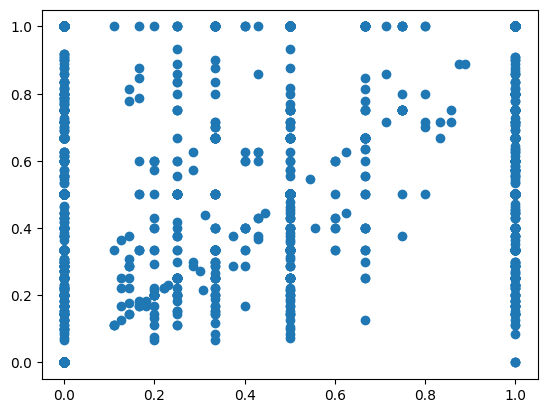

In [31]:
plt.scatter(content["miss_ratios_core0_detailled"][:,row,bank],content["miss_ratios_detailled"][:,row,bank])

In [38]:
F = Features()

In [39]:
G = GoalGenerator()

TypeError: GoalGenerator.__init__() missing 2 required positional arguments: 'num_bank' and 'modules'